<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Traffic-forecasting/blob/main/Notebooks/EDA_traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from tqdm import tqdm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib import style
import statsmodels.api as sm
%matplotlib inline
warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
!gdown 113Jq2I2ZHWj0CwxdLxt3yBID_53RroCR # Load dataset
!unzip -qq "/content/IntraTM.zip" -d "/content/files" # unzip to a folder called files

Downloading...
From: https://drive.google.com/uc?id=113Jq2I2ZHWj0CwxdLxt3yBID_53RroCR
To: /content/IntraTM.zip
100% 10.8M/10.8M [00:00<00:00, 124MB/s]


# Create a text file

In [3]:
!ls "/content/files" >> "/content/file_names.txt" # Create a text file and store all files' names inside

with open('/content/file_names.txt','r') as file: # read this file
    files_names =file.read().splitlines()


print("first name is : ",files_names[0])
print("second name is: ",files_names[1])
print("...")
print("...")
print("...")
print("last name is :",files_names[-1])

first name is :  IntraTM-2005-01-01-00-30.xml
second name is:  IntraTM-2005-01-01-00-45.xml
...
...
...
last name is : IntraTM-2005-01-31-23-45.xml


# extract information from all files using their names

In [5]:
def create_list_of_dfs(files_names):

  """Input: names of files in the dataset folder as a list
     Output: a list of dataframes for all files"""


  dataframe_list =  list()

  for index,file_name in enumerate(tqdm(files_names,"Processing")): # Iterate over files

      df = pd.DataFrame({})
      file_path = '/content/files/'+ file_name

      tree = ET.parse(file_path) # parsing the file
      root = tree.getroot()
      date = file_name.split(".")[0].split("IntraTM-")[1] # extracting only date from file_name
      #eg : file_path="/content/files/IntraTM-2005-01-01-00-30.xml" ,
      #date = 2005-01-01-00-30


      # fixed variables to store values
      src_id_list  = list()
      dst_id_list = list()
      traffic_list =  list()


      for src in root.findall(".//src"):  # finding where we have src in html file
          src_id = src.get('id') #  receive src_id

          for dst in src.findall('dst'): # run a loop for that src to find all destinations
              dst_id = dst.get('id')  # receive dst id
              traffic = dst.text   # dst value

              src_id_list.append(int(src_id)) # store src_id
              dst_id_list.append(int(dst_id)) # store dst_id
              traffic_list.append(float(traffic)) # store traffic

      # add values to the dataframe
      df.insert(loc=0,column="src_id",value=src_id_list)
      df.insert(loc=1,column="dst_id",value=dst_id_list)
      df.insert(loc=2,column=f'{date}',value=traffic_list)

      # add dataframe to a list
      dataframe_list.append(df)

  return dataframe_list



dataframe_list = create_list_of_dfs(files_names)

number_of_files = len(dataframe_list)
print('Number_of_files:',number_of_files)



# Let's see two dataframes
print('First dataframe')
display(dataframe_list[0])
print('Second dataframe')
display(dataframe_list[1])

Processing: 100%|██████████| 2941/2941 [00:13<00:00, 223.75it/s]


Number_of_files: 2941
First dataframe


,src_id,dst_id,2005-01-01-00-30
0,12,12,396708.2311
1,12,13,28093.7511
2,12,19,16916.5600
3,12,23,3662.8089
4,12,8,6552.9333
...,...,...,...
472,15,14,0.4622
473,15,11,496.4711
474,15,9,3781.9644
475,15,17,889.2267


Second dataframe


,src_id,dst_id,2005-01-01-00-45
0,12,12,338875.5644
1,12,13,28485.3422
2,12,19,11769.3422
3,12,23,1950.5067
4,12,8,5445.9111
...,...,...,...
470,15,14,3.1644
471,15,11,493.4844
472,15,9,888.7289
473,15,17,8000.8178


# Merge all dataframes together

In [6]:
# Initialize the merged DataFrame with the first DataFrame in the list
df = dataframe_list[0]

# Iterate over the remaining DataFrames and perform an outer join
for dataframe in tqdm(dataframe_list[1:]):
    df = pd.merge(df, dataframe, on=['src_id', 'dst_id'], how='outer')


#save as a csv file
df.to_csv('df.csv',index=False)

100%|██████████| 2940/2940 [01:36<00:00, 30.43it/s]


# EDA on data

In [7]:
df = pd.read_csv("/content/df.csv")
display(df)

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.2311,338875.5644,341894.5422,347749.5822,320159.4933,336569.9733,304732.9422,318965.9822,...,311502.9422,317854.7644,315334.9156,320295.8133,318063.6711,320748.4711,298609.4489,297175.1556,305258.2222,310534.2756
1,12,13,28093.7511,28485.3422,38402.6756,31250.8356,50818.0000,20076.4000,33443.3600,40365.1111,...,30722.8444,31104.5422,47739.3156,35189.5644,33934.6667,30320.1689,25305.5378,26145.2978,28801.8756,30300.6667
2,12,19,16916.5600,11769.3422,5830.6311,7052.6489,6173.0222,4775.5111,5676.6489,4924.9511,...,3370.6400,1122.3911,1256.7911,2634.7289,3196.2667,4596.8444,7102.2844,5395.0400,4077.1556,10089.4489
3,12,23,3662.8089,1950.5067,2293.3778,1915.7244,1556.5333,1623.6089,1072.9422,855.4222,...,194.0889,726.8267,4217.2444,16669.8222,17209.4222,8732.4267,62.8800,412.2133,166.9067,119.0400
4,12,8,6552.9333,5445.9111,5831.0578,5757.1556,5453.6000,5178.4000,7083.3333,8414.4267,...,2915.8933,2589.1467,4792.2933,4280.5689,3852.2133,2539.4667,2017.9289,1540.2044,1812.3022,1205.4667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.8178,NaN,NaN,0.8178,NaN,1.6356,0.8178,NaN,0.8178
519,16,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,20,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
column_names = df.columns
features = column_names[2:]

In [9]:
#change float 64 to 16 for traffic to decrease computation ahead
print("*"*100)
print('Original inforamtion of dataframe:')
print("*"*100)
df.info()
print("*"*100)
print('Updated inforamtion of dataframe with lower memory:')
print("*"*100)
df[features] = df[features].astype(np.float32)
df.info()

****************************************************************************************************
Original inforamtion of dataframe:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float64(2941), int64(2)
memory usage: 11.7 MB
****************************************************************************************************
Updated inforamtion of dataframe with lower memory:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float32(2941), int64(2)
memory usage: 5.9 MB


In [ ]:
# Look at self-loop in the dataframe
# print('The following nodes have self_loop to theirselves in several times.')
# self_loop_nodes = np.sort(df[df['src_id']==df['dst_id']]['src_id'].values)
# self_loop_nodes
# Dropping self_loop_nodes
# df.drop(df[df['src_id']==df['dst_id']].index,inplace=True)
#display(df)

## Check nan items

In [10]:
nan_counts = df.isnull().sum(axis=1)
nan_counts


0         0
1         0
2         0
3         1
4         0
       ... 
517    2935
518    2821
519    2939
520    2939
521    2939
Length: 522, dtype: int64

## Remove those with nan values more than 25%

In [11]:
index_list_to_remove  = list()
nan_counts_index = nan_counts.index
nan_count_values = nan_counts.values
for nan_value_index,nan_value  in zip(nan_counts_index,nan_count_values):
  if (nan_value/number_of_files)*100 >25:
    index_list_to_remove.append(nan_value_index)

print("This indexes have more nan values, so we need to remove them")
print(index_list_to_remove)

This indexes have more nan values, so we need to remove them
[13, 33, 54, 66, 75, 77, 83, 87, 96, 98, 127, 137, 159, 180, 202, 213, 216, 223, 244, 245, 264, 286, 298, 299, 300, 304, 309, 326, 336, 337, 352, 365, 366, 385, 407, 429, 451, 472, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521]


In [12]:
df.drop(index_list_to_remove,inplace=True)
display(df)

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
1,12,13,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
2,12,19,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
3,12,23,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,16669.822266,17209.421875,8732.426758,62.880001,412.213287,166.906693,119.040001
4,12,8,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,15,2,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
473,15,11,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
474,15,9,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607
475,15,17,889.226685,8000.817871,3387.182129,544.746704,453.786713,941.253296,4769.849121,5940.586914,...,171.235596,355.911102,450.577789,760.711121,8573.040039,695.128906,689.431091,2366.382080,381.626709,228.142197


In [13]:
df.isnull().sum(axis=1)

0       0
1       0
2       0
3       1
4       0
       ..
471     0
473    25
474     0
475     0
476     0
Length: 439, dtype: int64

In [14]:
# Fill others with forward fill method

In [15]:
df.fillna(axis='index',method="ffill",inplace= True)


In [20]:
number_of_nans = df.isnull().sum(axis=1).values
sum =0
for item in number_of_nans:
  if item >0:
    sum +=1

if sum >0:
  print('Check nan-values')
else:
  print("There is no nan values")

There is no nan values


# Plot graph

In [21]:
def plot_graph(dataframe,row):
  fig, ax = plt.subplots(figsize=(12, 4))
  plt.style.use('ggplot')

  data = dataframe.iloc[row,2:]
  src_id = df.loc[row][0]
  dst_id = df.loc[row][1]

  data.plot(label=f'src_id:{int(src_id)},dst_id:{int(dst_id)}',color='blue')
  plt.grid(True, color='brown', linestyle='--', alpha=0.5)


  # Define the positions for x-ticks (e.g., every 50th point)
  positions = range(0, len(data), 100)
  # Define the corresponding labels for these positions

  labels = [features[i] for i in positions]

  # Set the positions and labels of the x-ticks
  ax.set_xticks(positions)
  ax.set_xticklabels(labels, rotation=90)  # Rotation to vertical
  plt.legend()



  # Show the plot
  plt.show()



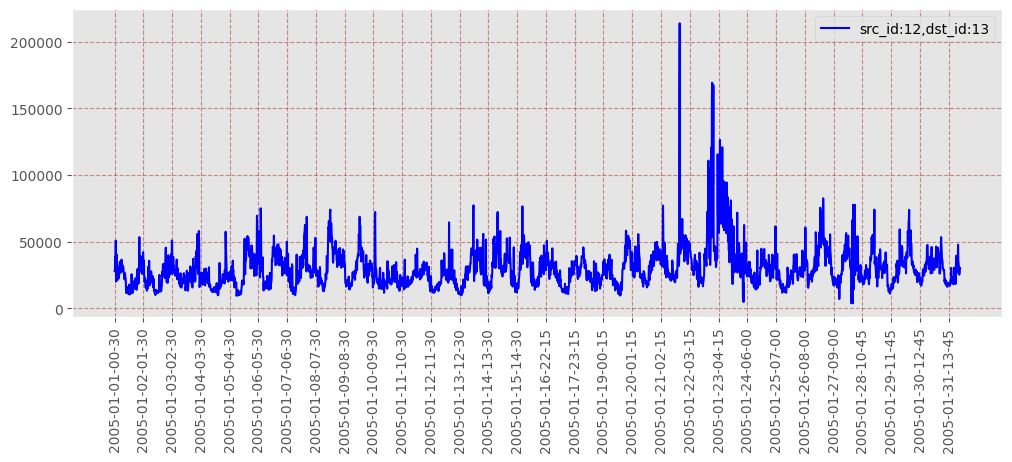

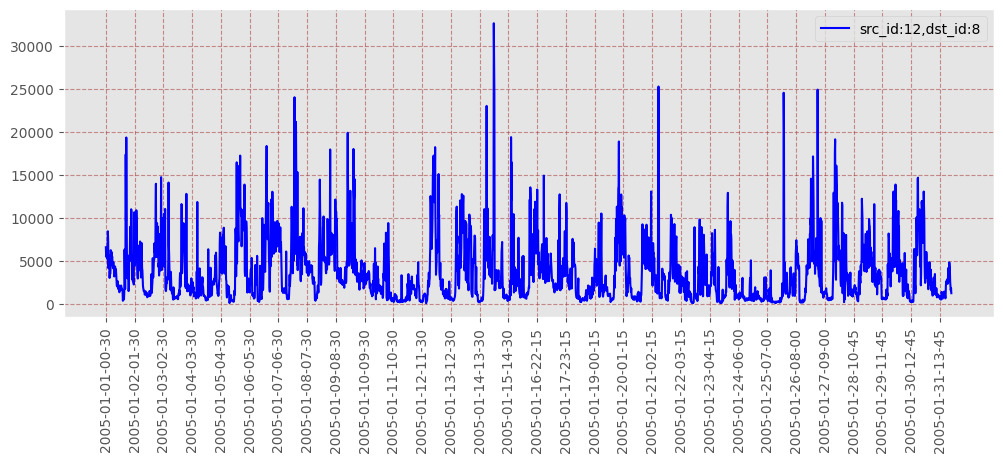

In [23]:
plot_graph(df,1)
plot_graph(df,4)

# Stationarity
Stationarity is one of the most important properties of time series.

But what does it mean for data to be stationary?

If a time series is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called homoscedasticity). Also, it should not contain seasonality. We can then summarize the 3 main characteristics as follows:

Constant mean
Constant variance
No seasonality
We can easily see these features visually on the below images:

The time series below is not stationary because the mean increases over time (i.e., it is a function of time).





**Interpreting the ADF test results**

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

**p-value > 0.05:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [24]:
def check_stationary(dataframe,row):
  X = dataframe.iloc[row,2:]

  print('*'*100)
  adfuller_result = adfuller(X)
  print('ADF Statistic: %f' % adfuller_result[0])
  if adfuller_result[1] <= 0.1:

    print('p-value: %f' % adfuller_result[1],'\t\t\t ***Stationary***')

  else:
    print('p-value: %f' % adfuller_result[1],'\t\t\t ***Non-Stationary***')

  print('Critical Values:')
  for key, value in adfuller_result[4].items():
      print('\t%s: %.3f' % (key, value))


  print('*'*100)
  kpss_result = kpss(X)
  print('KPSS Statistic: %f' % kpss_result[0])
  if kpss_result[1] <= 0.1:

    print('p-value: %f' % kpss_result[1],'\t\t\t ***Stationary***')

  else:
    print('p-value: %f' % kpss_result[1],'\t\t\t ***Non-Stationary***')

  print('Critical Values:')
  for key, value in kpss_result[3].items():
      print('\t%s: %.3f' % (key, value))

In [25]:
check_stationary(df,2)

****************************************************************************************************
ADF Statistic: -7.699552
p-value: 0.000000 			 ***Stationary***
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
****************************************************************************************************
KPSS Statistic: 0.177601
p-value: 0.100000 			 ***Stationary***
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [26]:
def check_stationary_for_all_data(dataframe):
  number_of_rows =  dataframe.shape[0]
  stationary_list = list()
  adfuller_result_list = list()
  kpss_result_list = list()

  for row in tqdm(range(number_of_rows)):

    X = dataframe.iloc[row,2:]
    adfuller_result = adfuller(X)
    kpss_result = kpss(X)
    if adfuller_result[1] <= 0.05:
       adfuller_result_list.append(1)
    else:
      adfuller_result_list.append(0)

    if kpss_result[1] <= 0.05:
       kpss_result_list.append(1)
    else:
      kpss_result_list.append(0)


    if adfuller_result[1] <= 0.05 and kpss_result[1] <= 0.05:
      stationary_list.append(1)
    else:
      stationary_list.append(0)

  stationary_df = pd.DataFrame()
  stationary_df.insert(loc=0,column="src_id",value=dataframe['src_id'])
  stationary_df.insert(loc=1,column="dst_id",value=dataframe['dst_id'])
  stationary_df.insert(loc=2,column="ADF",value=adfuller_result_list)
  stationary_df.insert(loc=3,column="KPSS",value=kpss_result_list)
  stationary_df.insert(loc=4,column='Stationary',value=stationary_list)

  return stationary_df


In [27]:
stationary_df = check_stationary_for_all_data(dataframe = df)

100%|██████████| 439/439 [01:02<00:00,  7.05it/s]


In [90]:
stationary_df

,src_id,dst_id,ADF,KPSS,Stationary
0,12,12,1,0,0
1,12,13,1,1,1
2,12,19,1,0,0
3,12,23,1,0,0
4,12,8,1,0,0
...,...,...,...,...,...
471,15,2,1,0,0
473,15,11,1,0,0
474,15,9,1,0,0
475,15,17,1,0,0


In [29]:
np.unique(stationary_df['Stationary'],return_counts=True)

(array([0, 1]), array([276, 163]))

In [91]:
df_ts = df.drop(['src_id', 'dst_id'], axis=1) # Remove src and dst columns
df_ts

,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,2005-01-01-02-30,2005-01-01-02-45,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,313401.906250,347195.343750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
1,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,30642.080078,34432.773438,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
2,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,4945.306641,5441.315430,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
3,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,2896.497803,3293.386719,...,194.088898,726.826721,4217.244629,16669.822266,17209.421875,8732.426758,62.880001,412.213287,166.906693,119.040001
4,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,7294.720215,4109.404297,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,411.573303,535.466675,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
473,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,75.306702,146.284393,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
474,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,627.786682,561.422180,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607
475,889.226685,8000.817871,3387.182129,544.746704,453.786713,941.253296,4769.849121,5940.586914,2600.355713,603.751099,...,171.235596,355.911102,450.577789,760.711121,8573.040039,695.128906,689.431091,2366.382080,381.626709,228.142197


In [96]:
transpose_df = df_ts.T
column_names = [ f'traffic_{i}' for i in range(439)]
transpose_df.columns = column_names
transpose_df.insert (loc=0,column='Timestamp', value=features)
transpose_df.to_csv('transpose.csv',index=False)

In [99]:
data_set = pd.read_csv('/content/transpose.csv',infer_datetime_format=True,parse_dates=["Timestamp"],index_col=["Timestamp"])

In [112]:
data_set

,traffic_0,traffic_1,traffic_2,traffic_3,traffic_4,traffic_5,traffic_6,traffic_7,traffic_8,traffic_9,...,traffic_429,traffic_430,traffic_431,traffic_432,traffic_433,traffic_434,traffic_435,traffic_436,traffic_437,traffic_438
Timestamp,,,,,,,,,,,,,,,,,,,,,
2005-01-01-00-30,396708.22,28093.752,16916.5600,3662.8088,6552.9330,3224.9155,124992.720,14946.8970,22715.8670,19470.0350,...,2336.9512,293.1289,1802.4711,874.9600,284.9511,1326.9244,496.4711,3781.9644,889.2267,195.5733
2005-01-01-00-45,338875.56,28485.342,11769.3420,1950.5067,5445.9110,3609.4312,120400.450,15535.5110,10914.4090,13298.2130,...,2371.8580,328.0800,3530.1245,792.0000,238.2311,572.4444,493.4844,888.7289,8000.8180,456.2844
2005-01-01-01-00,341894.53,38402.676,5830.6310,2293.3777,5831.0576,2437.8933,116800.336,9294.8270,14483.2890,6874.5513,...,2610.1420,374.4622,10383.1550,722.2933,118.3733,533.7867,292.0711,1063.5111,3387.1821,302.8978
2005-01-01-01-15,347749.60,31250.836,7052.6490,1915.7244,5757.1560,5009.3066,121722.000,7730.6760,11299.5640,8527.2350,...,3827.9556,304.7289,11737.0400,660.1422,185.8578,556.6044,182.4889,1211.8756,544.7467,487.1733
2005-01-01-01-30,320159.50,50818.000,6173.0220,1556.5333,5453.6000,2749.4934,122505.734,6687.3510,17763.6270,14645.1380,...,5485.3066,497.3422,738.2933,767.3511,133.2178,575.7956,267.8222,1142.7200,453.7867,238.1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-01-31-22-45,320748.47,30320.168,4596.8440,8732.4270,2539.4668,72451.9840,43045.670,7434.0620,4875.1560,9088.2310,...,736.8267,144.6844,86.8267,74.8889,46.5778,198.8267,14.7200,508.0444,695.1289,509.0044
2005-01-31-23-00,298609.44,25305.537,7102.2840,62.8800,2017.9290,69769.1640,40503.510,8444.5870,5573.9644,9743.2000,...,680.0622,171.1911,114.8978,23.4756,94.4622,123.5556,0.4356,977.6889,689.4311,784.5956
2005-01-31-23-15,297175.16,26145.297,5395.0400,412.2133,1540.2043,81901.6950,32628.996,7844.9424,6161.5200,12359.0400,...,469.3156,177.9822,115.1822,28.2756,42.9867,43.8667,0.4622,1867.6622,2366.3820,1014.7289


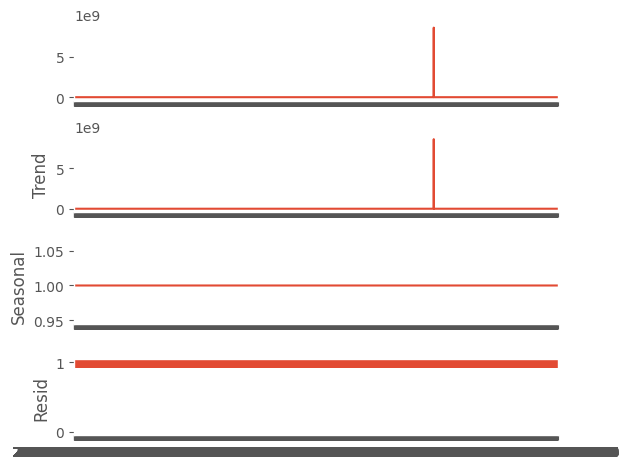

In [116]:
# decompose with additive model (seasonal, trend and resid)
mul_decomposition = sm.tsa.seasonal_decompose(data_set[['traffic_0']], model = 'multiplicative',period=1)
x = mul_decomposition.plot()

In [117]:
multiplicative_decomposition.resid

Timestamp
2005-01-01-00-30   NaN
2005-01-01-00-45   NaN
2005-01-01-01-00   NaN
2005-01-01-01-15   NaN
2005-01-01-01-30   NaN
                    ..
2005-01-31-22-45   NaN
2005-01-31-23-00   NaN
2005-01-31-23-15   NaN
2005-01-31-23-30   NaN
2005-01-31-23-45   NaN
Name: resid, Length: 2941, dtype: float64

In [172]:
df_long['traffic_0']

2005-01-01 00:30:00    396708.21875
2005-01-01 00:45:00    338875.56250
2005-01-01 01:00:00    341894.53125
2005-01-01 01:15:00    347749.59375
2005-01-01 01:30:00    320159.50000
                           ...     
2005-01-31 22:45:00    320748.46875
2005-01-31 23:00:00    298609.43750
2005-01-31 23:15:00    297175.15625
2005-01-31 23:30:00    305258.21875
2005-01-31 23:45:00    310534.28125
Freq: 15T, Name: traffic_0, Length: 2974, dtype: float32

In [175]:
df_long['traffic_0'].isnull().sum()

0

In [174]:
df_long['traffic_0'].fillna(method='ffill',inplace=True)

In [176]:
# decompose with additive model (seasonal, trend and resid)
add_decomposition = sm.tsa.seasonal_decompose(df_long['traffic_0'], model = 'additive')
x = add_decomposition.plot()

ValueError: freq T not understood. Please report if you think this is in error.